In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [2]:
upload = files.upload()
data = pd.read_csv("train.csv")
data.head()

Saving train.csv to train.csv


,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [3]:
data.describe()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
count,38932,38932,38932,38932,38932
unique,38932,38932,11,3,2
top,id10326,The room was kind of clean but had a VERY stro...,Firefox,Desktop,happy
freq,1,1,7367,15026,26521


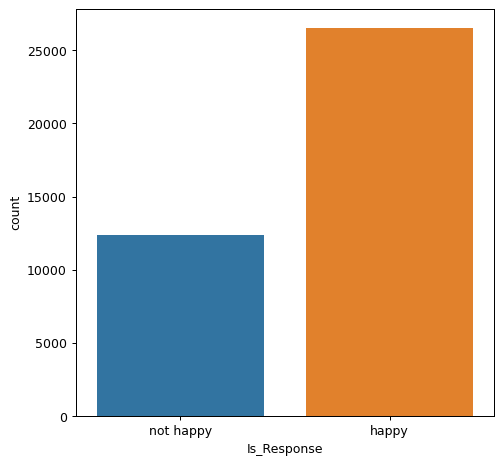

In [10]:
# lets check whether the target column is balanced or not
plt.figure(figsize=(6,6), dpi=90)
sns.countplot(data=data, x="Is_Response")
plt.show()

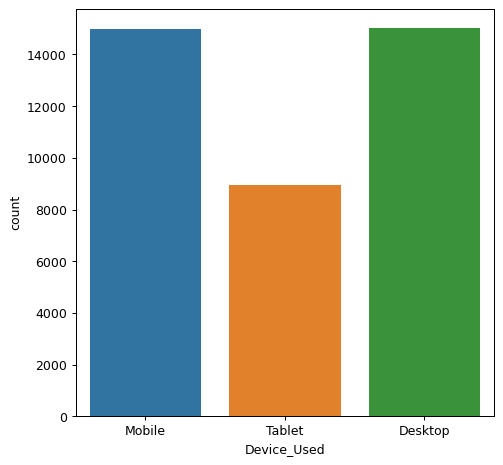

In [9]:
plt.figure(figsize=(6,6), dpi=90)
sns.countplot(data=data, x="Device_Used")
plt.show()

In [11]:
data.isnull().sum()

User_ID         0
Description     0
Browser_Used    0
Device_Used     0
Is_Response     0
dtype: int64

In [14]:
data["Is_Response"].unique()

array(['not happy', 'happy'], dtype=object)

In [16]:
# lets check what type of reviews have customers written
for i in data["Description"][:10]:
  print(i)

The room was kind of clean but had a VERY strong smell of dogs. Generally below average but ok for a overnight stay if you're not too fussy. Would consider staying again if the price was right. Breakfast was free and just about better than nothing.
I stayed at the Crown Plaza April -- - April --, ----. The staff was friendly and attentive. The elevators are tiny (about -' by -'). The food in the restaurant was delicious but priced a little on the high side. Of course this is Washington DC. There is no pool and little for children to do. My room on the fifth floor had two comfortable beds and plenty of space for one person. The TV is a little small by todays standards with a limited number of channels. There was a small bit of mold in the bathtub area that could have been removed with a little bleach. It appeared the carpets were not vacummed every day. I reported a light bulb was burned out. It was never replaced. Ice machines are on the odd numbered floors, but the one on my floor did

In [45]:
# cleaning txt reviews
import re
def clean(x):
  txt = re.sub("[-,().#!@$\"]", "", x)
  if  not re.search("\w+n't", txt) or re.search("\w*'d", txt):
    txt = re.sub("[']", "", txt)
  txt = txt.lower()
  return txt

In [37]:
for i in data["Description"].apply(clean)[:10]:
  print(i)

the room was kind of clean but had a very strong smell of dogs generally below average but ok for a overnight stay if youre not too fussy would consider staying again if the price was right breakfast was free and just about better than nothing
i stayed at the crown plaza april   april   the staff was friendly and attentive the elevators are tiny about  by  the food in the restaurant was delicious but priced a little on the high side of course this is washington dc there is no pool and little for children to do my room on the fifth floor had two comfortable beds and plenty of space for one person the tv is a little small by todays standards with a limited number of channels there was a small bit of mold in the bathtub area that could have been removed with a little bleach it appeared the carpets were not vacummed every day i reported a light bulb was burned out it was never replaced ice machines are on the odd numbered floors but the one on my floor did not work i encountered some staff

In [46]:
data["cleaned"] = data["Description"].apply(clean)

In [48]:
# now if you look at it
# data.drop(["User_ID","Browser_Used"], axis=1, inplace=True)
data.head()

,Description,Device_Used,Is_Response,cleaned
0,The room was kind of clean but had a VERY stro...,Mobile,not happy,the room was kind of clean but had a very stro...
1,I stayed at the Crown Plaza April -- - April -...,Mobile,not happy,i stayed at the crown plaza april april th...
2,I booked this hotel through Hotwire at the low...,Tablet,not happy,i booked this hotel through hotwire at the low...
3,Stayed here with husband and sons on the way t...,Desktop,happy,stayed here with husband and sons on the way t...
4,My girlfriends and I stayed here to celebrate ...,Tablet,not happy,my girlfriends and i stayed here to celebrate ...


In [51]:
data["cleaned"] = data["cleaned"].apply(lambda x : re.sub("[\n]","", x))

In [52]:
data["cleaned"].apply(lambda x: re.search("\n", x)).value_counts()

Series([], Name: cleaned, dtype: int64)

# model building

In [53]:
x = data["cleaned"]
y = data["Is_Response"]

In [59]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=21)

In [61]:
# we shall use TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tf = TfidfVectorizer()
lr = LogisticRegression(n_jobs=-1)

In [62]:
# we will use pipeline to execute two things right after one another 
from sklearn.pipeline import Pipeline

#so pipeline takes few arguments which also includes classifer models, vectorizer objs
model = Pipeline([("vectorizer",tf), ("classifier",lr)])

# and then we fit the xtrain/ytrain
model.fit(x_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression(n_jobs=-1))])

In [73]:
# evaluation of model
y_pred = model.predict(x_test)

# evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(accuracy_score(y_test, y_pred))
print("-"*56)
print(classification_report(y_test, y_pred))
print("-"*56)
print(confusion_matrix(y_test, y_pred))

0.8785154745087967
--------------------------------------------------------
              precision    recall  f1-score   support

       happy       0.89      0.93      0.91      5253
   not happy       0.85      0.76      0.80      2534

    accuracy                           0.88      7787
   macro avg       0.87      0.85      0.86      7787
weighted avg       0.88      0.88      0.88      7787

--------------------------------------------------------
[[4910  343]
 [ 603 1931]]


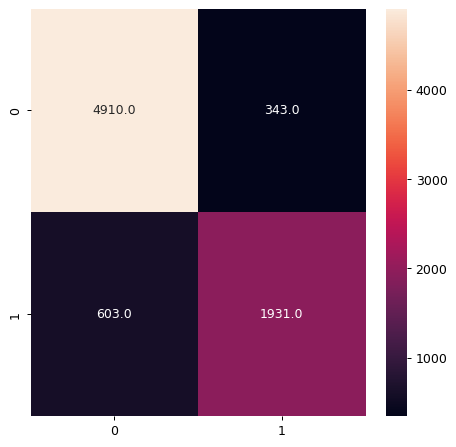

In [74]:
plt.figure(figsize=(6,6), dpi=90)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".1f")
plt.show()

In [88]:
def write_review():
  output = []
  review = input("How was your experience: ")
  output.append(clean(review))
  output = model.predict(output)
  return output

In [96]:
print(write_review())

How was your experience: my friend shitted in the hall way
['happy']
